# Magnetization

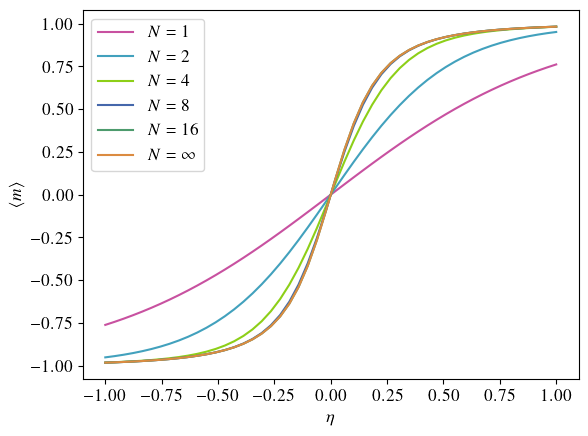

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("../custom.matplotlibrc")

def lambda_plus(zeta, eta):
    c = np.cosh(eta)
    s = np.sinh(eta)
    
    return np.exp(zeta) * (c + np.sqrt(s**2 + np.exp(-4 * zeta)))

def lambda_minus(zeta, eta):
    c = np.cosh(eta)
    s = np.sinh(eta)
    
    return np.exp(zeta) * (c - np.sqrt(s**2 + np.exp(-4 * zeta)))

def magnetization(zeta, eta, N):
    s = np.sinh(eta)
    c = np.cosh(eta)
    
    lp = lambda_plus(zeta, eta)
    lm = lambda_minus(zeta, eta)
    
    fac = c / np.sqrt(s**2 + np.exp(-4 * zeta))
    
    return N * np.exp(zeta) * s  / (np.power(lp, N) + np.power(lm, N)) * (np.power(lp, N-1) * (1 + fac) + np.power(lm, N-1) * (1 - fac))

def high_n_limit(zeta, eta):
    e = np.exp(-4*zeta)
    s = np.sinh(eta)
    
    return s / np.sqrt(s**2 + e)



r = 1
x = np.linspace(-r, r, 50)

zeta = 0.75
for n in [1, 2, 4, 8, 16]:
    plt.plot(x, magnetization(zeta, x, n) / n, label=f"$N = \\num{{{n}}}$")
plt.plot(x, high_n_limit(zeta, x), label=r"$N = \infty$")
plt.legend()
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\expval{m}$")
plt.savefig("magnetization.pdf")
# plt.ylim(-12, 12)

# Defining the System Class

In [2]:
class SpinSystem:
    """

    A class that calculates the Action of a given spin configuration

    :param spin_config: Array of +/- 1 values
    :param float zeta: ζ = J / T dimensionless parameter for coupling spin strength
    :param float eta: η = h / T dimensionless parameter for magnetic field strengh
    :param int n: Number of spins

    """

    def __init__(self, zeta: float, eta: float, n: int):
        self.zeta = zeta
        self.eta = eta
        self.n = n

    def action(self, spin_config: np.ndarray):
        if spin_config.__len__() != self.n:
            raise ValueError(f"spin_config has to have the dimension {self.n}")

        # This did not factor in periodic boundary conditions
        # h = (spin_config[:-1] * spin_config[1:]).sum()
        h = (spin_config * np.roll(spin_config, 1)).sum()

        return - self.zeta * h - self.eta * spin_config.sum()

    def delta_action(self, spin_config: np.ndarray, spin_flip: int | np.ndarray):
        """

        Calculates the difference in the action of a given configuration, if a spin_flip at one position occurs.

        :param int | np.ndarray spin_flip: index of spin flip position.

        """

        # # error with boundaries
        # if spin_flip == 0:
        #     return 2 * spin_config[0] * (self.eta + self.zeta * spin_config[1])
        # elif spin_flip == self.n - 1:
        #     return 2 * spin_config[spin_flip] * (self.eta + self.zeta * spin_config[spin_flip - 1])

        spin = spin_config[spin_flip]
        left_spin = np.roll(spin_config, 1)[spin_flip]
        right_spin = np.roll(spin_config, -1)[spin_flip]
        
        return 2 * spin * (self.eta + self.zeta * (left_spin + right_spin))
    
    def magnetization(self, spin_config) -> np.ndarray:
        return spin_config.sum(axis=1) / self.n

    def generate_spin_config(self):
        return np.random.choice([-1, 1], size=self.n)

# $S$ and $\Delta S$ scaling

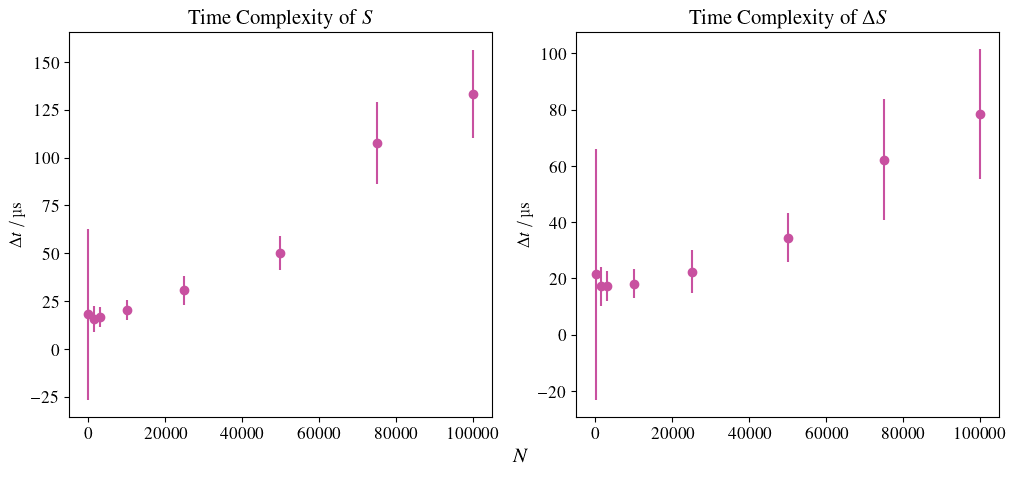

In [3]:
from time import time_ns

action_time_averages = []
delta_action_time_averages = []
action_time_std = []
delta_action_time_std = []

barstyle = {
    "lines.linestyle": "",
    "lines.marker": "o"
}

spin_numbers = [50, 1_500, 3_000, 10_000, 25_000, 50_000, 75_000, 100_000]

for n in spin_numbers:
    system = SpinSystem(zeta=.75, eta=0.5, n=n)

    action_times = []
    delta_action_times = []
    
    for _ in range(1000):
        config = system.generate_spin_config()

        start = time_ns()
        system.action(config) 
        action_times.append((time_ns() - start) / 1000)

        start = time_ns()
        system.delta_action(config, 1)
        delta_action_times.append((time_ns() - start) / 1000)
    
    action_time_averages.append(np.mean(action_times))
    action_time_std.append(np.std(delta_action_times))
    delta_action_time_averages.append(np.mean(delta_action_times))
    delta_action_time_std.append(np.std(delta_action_times))
        

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

with plt.rc_context(barstyle):
    ax[0].errorbar(spin_numbers, action_time_averages, yerr=action_time_std)
    ax[1].errorbar(spin_numbers, delta_action_time_averages, yerr=delta_action_time_std)
    
    ax[0].set_ylabel(r"$\Delta t \,/\, \unit{\micro\second}$")
    ax[0].set_title(r"Time Complexity of $S$")
    ax[1].set_ylabel(r"$\Delta t \,/\, \unit{\micro\second}$")
    ax[1].set_title(r"Time Complexity of $\Delta S$")
    fig.supxlabel(r"$N$")
    fig.savefig("action_spin_number_scaling.pdf")


# MCMC

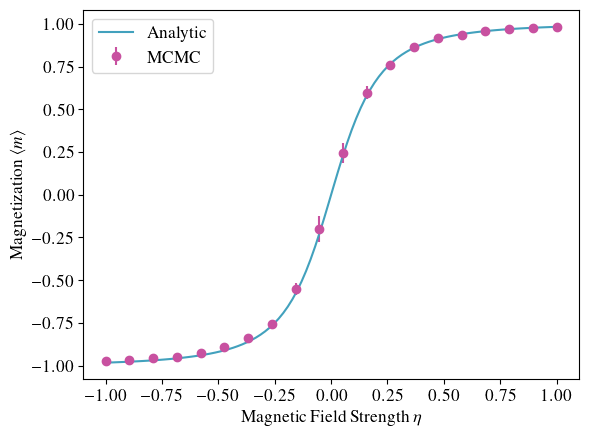

In [4]:
from copy import deepcopy


class IsingModelMCMC:
    def __init__(self, spin_system: SpinSystem):
        self.spin_system = spin_system

    def calculate_next(self, spin_config) -> any:
        spin_flip = np.random.choice(range(self.spin_system.n))

        acceptance = min(
            1, np.exp(-self.spin_system.delta_action(spin_config, spin_flip))
        )
        u = np.random.uniform(0, 1)
        if acceptance >= u:
            new_config = deepcopy(spin_config)
            new_config[spin_flip] *= -1
            return new_config
        return spin_config

    def __call__(self, start_config: np.ndarray, array_length: int) -> np.ndarray:
        """Generate a Markov Chain"""

        configs = [start_config]
        for _ in range(1, array_length):
            new = self.calculate_next(configs[-1])
            configs.append(new)

        return np.array(configs)


from matplotlib.colors import LinearSegmentedColormap, to_hex

N = 20
CONFIGS = 10_000
NUMBER_OF_M_PER_ETA = 10

# cmap = LinearSegmentedColormap.from_list("colormap", list(zip([0, 0.5, 1], ["blue", "grey", "red"])))

# def get_color(x):
#     return to_hex(cmap(1/2 * (x + 1)))

# start_config = np.array([1, -1] * int(N / 2))
start_config = np.array([1] * N)
m = np.array([])
m_std = np.array([])
eta_values = np.linspace(-1, 1, 20)

# fig, ax = plt.subplots()
for eta in eta_values:
    system = SpinSystem(zeta=0.75, eta=eta, n=N)
    mcmc = IsingModelMCMC(system)

    values = np.array([])

    for _ in range(NUMBER_OF_M_PER_ETA):
        configs = mcmc(start_config, CONFIGS)
        mag = system.magnetization(configs)
        values = np.append(values, mag.mean())

    m = np.append(m, values.mean())
    m_std = np.append(m_std, values.std())


with plt.rc_context(barstyle):
    plt.errorbar(eta_values, m, yerr=m_std, label="MCMC")
    plt.xlabel(r"Magnetic Field Strength $\eta$")
    plt.ylabel(r"Magnetization $\langle m \rangle$")

eta = np.linspace(-1, 1, 100)
plt.plot(eta, magnetization(0.75, eta, N) / N, label=r"Analytic")
plt.legend()
plt.savefig(r"mean_magnetization_mcmc.pdf")